<h1 align="center"> Object Detection for VOC2007</h1>
<h4 align="center"> Competition 02 </h4>
<h4 align="center"> Team name: 讓我活下來 </h4>
<h4 align="center"> Members: 李泓緯、林孟萱、陳隆琦、陳家惠 </h4>

<div class="alert alert-block alert-info">
<b><font size="4">Info:</font></b> <font size="3">In this competition, we have to train a model that recognizes objects in an image. Your goal is to output bounding boxes for objects.</font>
</div>

# **Import package and load datasets**

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import random

from tensorflow import keras
from tensorflow.keras import layers

## image augmentation
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from shutil import copyfile
import os

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [11]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
PATH_TO_DATA = "./datalab-2021-cup2-object-detection"
DATA_PATH = PATH_TO_DATA + 'pascal_voc_training_data.txt'
IMAGE_DIR = PATH_TO_DATA + '/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 15

is_load_best = False

PROB_THRES = 0.01
IOU_THRES = 0.3

建立 class label 的視覺化，可以明顯看到 Class 14 (person) 的數量較其他 Class 高出許多，可以對較少量的 lable 的資料作重複增加來讓資料更加平衡

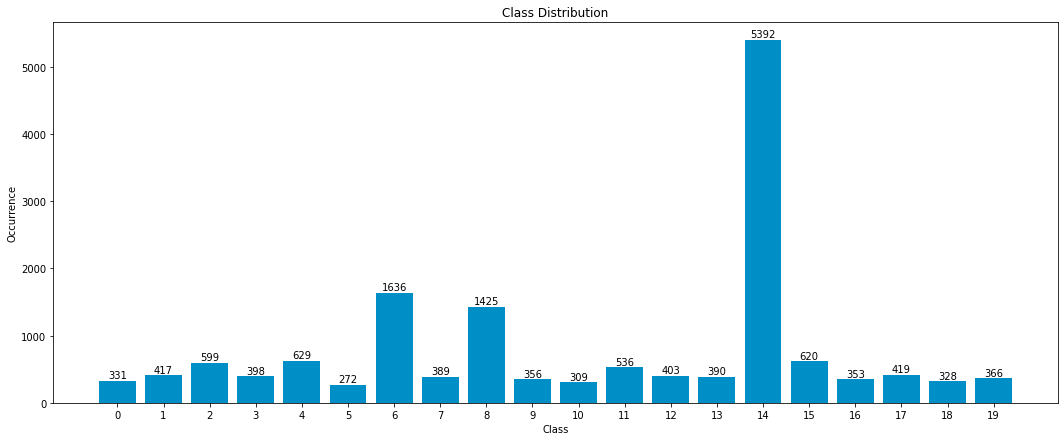

In [14]:
def createBarLabels(barplot):
    for item in barplot:
        plt.text(
            item.get_x()+item.get_width()/2., 
            item.get_height()*1.005, 
            '%d' % int(item.get_height()),
            ha = "center",
            va = "bottom",
        )

def balanced_label(data):

    label_dist = []
    for i, label_line in enumerate(data):
            label_line = label_line.strip().split()
            label_line = label_line[1:]
            length = len(label_line)//5
            for j in range(length):
                label_dist.append(label_line[j*5+4])

    label_class_dist = []

    for i, classi in enumerate(range(20)):
        label_class_dist.append((str(i), label_dist.count(str(classi))))

    return(label_class_dist)

training_data_label = open("./datalab-2021-cup2-object-detection/pascal_voc_training_data.txt", "r")
label_class_dist = balanced_label(training_data_label)

plt.figure(figsize=(18,7))
A = plt.bar(list(zip(*label_class_dist))[0],list(zip(*label_class_dist))[1], color = '#008EC7')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Occurrence')
createBarLabels(A)

# **Balance Data**

對少數 label 的資料做增加，讓資料更為平衡，幫助我們後面訓練模型時，模型在做預測時較不易被混淆

In [45]:
def list_add(a,b):
    c = []
    for i in range(len(a)):
        c.append(a[i]+b[i])
    return c

training_data_file = open("./datalab-2021-cup2-object-detection/pascal_voc_training_data.txt", "r")

train = []
new_count = []

for i, line in enumerate(training_data_file):
    line = line.strip()
    train.append(line)
    tmp = line.split()
    #print(tmp)
    count_tmp = np.zeros(len(classes_name))
    tmp_j = []
    for j in range(5, len(tmp), 5):
        tmp_j.append(tmp[j])
        
    for k in range(len(classes_name)):
        count_tmp[k] = tmp_j.count(str(k))

    new_count.append(count_tmp)

### index 5
for i in range(len(new_count)):
    if new_count[i][5] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 26):
            train.append(train[j])

### index 0
for i in range(len(new_count)):
    if new_count[i][0] > 0 and new_count[i][14] == 0 and new_count[i][6] == 0 and new_count[i][5] == 0 and new_count[i][8] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])


### index 1
for i in range(len(new_count)):
    if new_count[i][1] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 40):
            train.append(train[j])

### index 2
for i in range(len(new_count)):
    if new_count[i][2] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 6):
            train.append(train[j])

### index 3
for i in range(len(new_count)):
    if new_count[i][3] > 0 and new_count[i][14] == 0 and new_count[i][2] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 4
for i in range(len(new_count)):
    if new_count[i][4] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 6):
            train.append(train[j])

### index 7
for i in range(len(new_count)):
    if new_count[i][7] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 9
for i in range(len(new_count)):
    if new_count[i][9] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 15):
            train.append(train[j])

### index 10
for i in range(len(new_count)):
    if new_count[i][10] > 0 and new_count[i][14] < 2 and new_count[i][8] < 3:
        for j in np.repeat(i, 60):
            train.append(train[j])

### index 11
for i in range(len(new_count)):
    if new_count[i][11] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 12
for i in range(len(new_count)):
    if new_count[i][12] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 40):
            train.append(train[j])
            
### index 13
for i in range(len(new_count)):
    if new_count[i][13] > 0 and new_count[i][14] == 0 and new_count[i][6] == 0 and new_count[i][10] == 0:
        for j in np.repeat(i, 40):
            train.append(train[j])

### index 18
for i in range(len(new_count)):
    if new_count[i][18] > 0 and new_count[i][14] == 0 and new_count[i][6] == 0 and new_count[i][5] == 0 and new_count[i][8] == 0 and new_count[i][10] == 0:
        for j in np.repeat(i, 15):
            train.append(train[j])
            
### index 15
for i in range(len(new_count)):
    if new_count[i][15] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 3):
            train.append(train[j])
            
### index 16
for i in range(len(new_count)):
    if new_count[i][16] > 0 and new_count[i][14] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 17
for i in range(len(new_count)):
    if new_count[i][17] > 0 and new_count[i][14] == 0 and new_count[i][8] == 0 and new_count[i][15] == 0:
        for j in np.repeat(i, 10):
            train.append(train[j])

### index 19
for i in range(len(new_count)):
    if new_count[i][19] > 0 and new_count[i][14] == 0 and new_count[i][8] == 0 and new_count[i][10] == 0 and new_count[i][0] == 0 and new_count[i][18] == 0:
        for j in np.repeat(i, 20):
            train.append(train[j])

num = []
for line in train:
    line = line.strip()
    temp = line.split()
    for j in range(5,len(temp),5):
        num.append(temp[j])
result = Counter(num)

new_data = train

with open('./train_1.txt', 'w') as f:
    for item in new_data:
        f.write("%s\n" % item)

做完 data balance 後，在後面做預測時，發現效果會比原始的 imbalanced data 來得好，不過如果只做 balanced 的 data，成效仍然不是相當好，故考慮對 data 做 Augnentation，對模型餵進較多處理過資料，讓最後模型的成效更佳！

# **Data Augmentation**

定義 Augmentation 函數

In [46]:
@tf.function
def random_flip(image,xcenter,ycenter):
    up_down_outcome = tf.random.uniform([1],0,1)
    right_left_outcome = tf.random.uniform([1],0,1)

    x_0 = tf.not_equal(xcenter,0.)
    y_0 = tf.not_equal(ycenter,0.)
    grand = tf.cast(tf.where(tf.math.logical_or(x_0,y_0),IMAGE_SIZE,0),
                    tf.float32)

    if up_down_outcome<up_down_flip_p:
        image = tf.image.flip_up_down(image)
        ycenter = grand-ycenter

    if right_left_outcome<left_right_flip_p:
        image = tf.image.flip_left_right(image)
        xcenter = grand-xcenter

    return image, xcenter, ycenter

@tf.function
def to_gray(image):
    prob = tf.random.uniform([1],0,1)

    if prob<gray_p:
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.grayscale_to_rgb(image)

    return image

@tf.function
def gaussian_noise(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob<noise_p:
        noise = tf.random.normal(image.shape,stddev=5)
        image = tf.math.add(image, noise)
        
    return image

@tf.function
def brightness(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob<brightness_p:
        image = tf.image.random_brightness(image,5)
        
    return image

@tf.function
def hue(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < hue_p:
        image = tf.image.random_hue(image, 0.5)
        
    return image

@tf.function
def saturation(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < saturation_p:
        image = tf.image.random_saturation(image, 0, 1.5)
        
    return image

In [47]:
# data augumentation parameter
up_down_flip_p = 0.1
left_right_flip_p = 0.5

theSame = 0.1
# Probability for augumentation
crop_p = 0
geom_p = 0.8
gray_p = 0
noise_p = 0
hue_p = 0.8
saturation_p = 0.8
brightness_p = 0
contrast_p = 0
blur_p = 0

rotate_range=(-45, 45)
scale_range=(0.8, 1.2)
translate_range=(-0.2, 0.2)
shear_range=(-20, 20)
crop_pad_range=(-0.1, 0.1)

In [48]:
def imgaug_trans(image,labels):
    n = tf.math.count_nonzero(labels[:,0]).numpy()
    image = image.numpy()
    labels = labels.numpy()
    output = np.zeros_like(labels)

    center_x = labels[:,0]
    center_y = labels[:,1]
    w_half = labels[:,2] / 2
    h_half = labels[:,3] / 2

    tempbb = [BoundingBox(x1=center_x[i] - w_half[i], y1=center_y[i] - h_half[i],
                          x2=center_x[i] + w_half[i], y2=center_y[i] + h_half[i]) for i in range(n)]
    bbs = BoundingBoxesOnImage(tempbb, shape=image.shape)

    seq = iaa.Sequential(
      [
           iaa.Sometimes(geom_p,
                     iaa.SomeOf((1, 3), [
                                       iaa.Affine(translate_percent={"x":(translate_range[0], translate_range[1])},mode =ia.ALL),
                                       iaa.Affine(translate_percent={"y":(translate_range[0], translate_range[1])},mode = ia.ALL),
                                       iaa.Affine(scale=(scale_range[0], scale_range[1]),mode = ia.ALL)
                                       ],
                                random_order=True)
                     )
    ])

    image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

    if len(bbs_aug.remove_out_of_image().bounding_boxes)==n:
        theIdx = [i for i in range(n)]
    else:
        set_bb = set(bbs_aug.remove_out_of_image().bounding_boxes)
        theIdx = [i for i in range(n) if bbs_aug.bounding_boxes[i] in set_bb]

    selected_labels = labels[theIdx, 4]
    clip_bbs = bbs_aug.remove_out_of_image().clip_out_of_image().bounding_boxes
    for i in range(len(theIdx)):
        theBox = clip_bbs[i]
        output[i, 0] = (theBox.x1 + theBox.x2) / 2 # x center
        output[i, 1] = (theBox.y1 + theBox.y2) / 2 # y center
        output[i, 2] = (theBox.x2 - theBox.x1) # w
        output[i, 3] = (theBox.y2 - theBox.y1) # h
        output[i, 4] = selected_labels[i]

    return image_aug, output

In [49]:
@tf.function
def data_aug(image,labels):
    same_sample = tf.random.uniform([1],0,1)
    if same_sample > theSame:
        # not the same
        image, labels = tf.py_function(
            func=imgaug_trans,
            inp=[image,labels],
            Tout=[tf.float32,tf.float32]
            )
        image = hue(image)
        image = saturation(image)

    return image, labels

# **MODEL**

此處嘗試用了許多 pre-trained 模型：
1. 助教提供之 YOLO 
2. ResNet 152 替代前 20 層 layers，再加上兩層 Convolution + LeakyReLu 的 layers，最後連接全連結層和 output layer
3. 使用 Xception，再加上兩層 Convolution + MaxPool2D + BatchNormalization 的 layers，最後連接全連結層、Dropout 和 output layer

以上模型對 data 需要做前處理，所以 DatasetGenerator 會稍微不同

## **2. ResNet 152**

ResNet 透過增加層數來達到更好的低錯誤率表現，此作法為使用 Residual Mapping 解決超深神經網路的訓練難度，並且可以從 Model Architecture 看出此模型在 layers 連接時做了 shortcut 的動作，目的是可以學習到足夠 Residual 的 pattern，ResNet 152 也於 2015 年被提出，此模型涵蓋 152 層的 layers

In [51]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride)(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [52]:
pre_trained_model = tf.keras.applications.ResNet152(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pre_trained_model.trainable=False

In [53]:
x = pre_trained_model.output
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(CELL_SIZE*CELL_SIZE*(BOXES_PER_CELL*5+20),
                       activation='relu', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=pre_trained_model.input, outputs=outputs, name="YOLO")

In [50]:
### ResNet 152 DatasetGenerator
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            
            self.image_names.append(ss[0])
            self.record_list.append([float(num) for num in ss[1:]])
            self.object_num_list.append(min(len(self.record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
            
            # resize newest data
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
                
        ## shuffle
        idx = random.sample(range(len(self.image_names)), len(self.image_names))
        self.image_names = [self.image_names[i] for i in idx]
        self.record_list = [self.record_list[i] for i in idx]
        self.object_num_list = [self.object_num_list[i] for i in idx]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

        box_w = (xmax - xmin) * width_rate
        box_h = (ymax - ymin) * height_rate

        image, xcenter, ycenter = random_flip(image, xcenter, ycenter)

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)

        image, labels = data_aug(image, labels)
        image = tf.keras.applications.resnet.preprocess_input(image)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        ## 先做 shuffle 在做 batch
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return dataset

## **3. Xception**

ResNet 是為了更深的神經網路，那 Inception 家族就是為了更宽的神經網路。而 Xception 則表示「extreme inception」，此模型以 InceptionV3 為基礎去做改進，接者採用 depthwise separable convolution 來替代原本的 Inception module，並且加入了 ResNet 的 Residual Learning 概念

In [61]:
pre_trained_model = tf.keras.applications.xception.Xception(include_top=False,
                                                            weights='imagenet',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pre_trained_model.trainable=False

In [62]:
inputs_mdl = keras.models.Sequential()

inputs_mdl.add(layers.Conv2D(1024, (3,3), padding='same', activation='relu'))
inputs_mdl.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
inputs_mdl.add(layers.BatchNormalization())
inputs_mdl.add(layers.Conv2D(1024, (3,3), padding='same', activation='relu'))
inputs_mdl.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
inputs_mdl.add(layers.BatchNormalization())

inputs_mdl.add(layers.Flatten())
inputs_mdl.add(layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
inputs_mdl.add(layers.Dropout(0.5))
inputs_mdl.add(layers.Dense(512, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
inputs_mdl.add(layers.Dropout(0.5))
inputs_mdl.add(layers.Dense(CELL_SIZE*CELL_SIZE*(BOXES_PER_CELL*5+20),
                            activation='relu', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))

YOLO = keras.Model(inputs=pre_trained_model.input, outputs=inputs_mdl(pre_trained_model.output), name="YOLO")

In [7]:
### Xception DatasetGenerator
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            
            self.image_names.append(ss[0])
            self.record_list.append([float(num) for num in ss[1:]])
            self.object_num_list.append(min(len(self.record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
            
            # resize newest data
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
                
        ## shuffle
        idx = random.sample(range(len(self.image_names)), len(self.image_names))
        self.image_names = [self.image_names[i] for i in idx]
        self.record_list = [self.record_list[i] for i in idx]
        self.object_num_list = [self.object_num_list[i] for i in idx]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

        box_w = (xmax - xmin) * width_rate
        box_h = (ymax - ymin) * height_rate

        image, xcenter, ycenter = random_flip(image, xcenter, ycenter)

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)

        image, labels = data_aug(image, labels)
        image = tf.keras.applications.xception.preprocess_input(image)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        ## 先做 shuffle 在做 batch
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return dataset

# **Training**

## **Loss Function**

因為會對圖片進行翻轉，導致在計算 loss 時會出現 Error，因此此處有對助教 loss 的程式碼進行修改

In [ ]:
def yolo_loss(predicts, labels, objects_num):
    """
    calculate loss
    Args:
        predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
        labels : [max_objects, 5]  (x_center, y_center, w, h, class)
    """
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    batch_size = predicts.shape[0]
    loss = 0.

    for i in tf.range(batch_size):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #calculate objects tensor [CELL_SIZE, CELL_SIZE]
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    # min_x = tf.floor(min_x)
    # min_y = tf.floor(min_y)

    min_x = tf.maximum(tf.math.floor(min_x), 0) #
    min_y = tf.maximum(tf.math.floor(min_y), 0) #

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    temp = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    objects = tf.ones(temp, tf.float32)

    temp = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    temp = tf.reshape(temp, (2, 2))
    objects = tf.pad(objects, temp, "CONSTANT")

    #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
    #calculate responsible tensor [CELL_SIZE, CELL_SIZE]
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    temp = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                   tf.int32)
#     tmp = tf.stack([center_y, CELL_SIZE - center_y - 1,
#                     center_x, CELL_SIZE - center_x - 1])
    temp = tf.reshape(temp, (2, 2))
    response = tf.pad(response, temp, "CONSTANT")
    #objects = response

    #calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])

    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])
    #calculate C [cell_size, cell_size, boxes_per_cell]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    max_I = tf.reduce_max(I, 2, keepdims=True)

    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    #p_sqrt_w = tf.sqrt(tf.abs(predict_boxes[:, :, :, 2])) * ((tf.cast(predict_boxes[:, :, :, 2] > 0, tf.float32) * 2) - 1)
    #p_sqrt_h = tf.sqrt(tf.abs(predict_boxes[:, :, :, 3])) * ((tf.cast(predict_boxes[:, :, :, 3] > 0, tf.float32) * 2) - 1)
    #p_sqrt_w = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 2]))
    #p_sqrt_h = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 3]))
    #p_sqrt_w = predict_boxes[:, :, :, 2]
    #p_sqrt_h = predict_boxes[:, :, :, 3]
    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predict p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(objects, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE
    #class_loss = tf.nn.l2_loss(tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE
    #object_loss = tf.nn.l2_loss(I * (p_C - (C + 1.0)/2.0)) * OBJECT_SCALE

    #noobject_loss
    #noobject_loss = tf.nn.l2_loss(no_I * (p_C - C)) * NOOBJECT_SCALE
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                 tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                 tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                 tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

## **Import dataset**

在最初的模型 training 時計算 loss 有出現過 NaN，故在此處加入判斷式，如出現 NaN 停止迭代並輸出結果

In [143]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [144]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:n1], (-1, CELL_SIZE, CELL_SIZE, 20))
        scales = tf.reshape(outputs[:, n1:n2], (-1, CELL_SIZE, CELL_SIZE, 2))
        boxes = tf.reshape(outputs[:, n2:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
        predicts = tf.concat([class_probs, scales, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [145]:
from datetime import datetime

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        if idx == (len(dataset)-1):
            continue
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))
    
    x = float(train_loss_metric.result())
    if math.isnan(x):
        print("There is a NaN loss")
        break

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))  

2021-11-24 17:21:10.480349, start training.


# **Predict Test data**

## **Non-Maximum Suppression (NMS)**

助教提供的程式碼會將預測機率最高的 bounding box 和 label，但圖中可能會有多個 object，因此需要設閾值來將 confidence 較大的 object 預測出來，但這也有可能會有多個 bounding box 框住同一個 object，因此需要使用 Non-max suppression 的方式來將多個高度重疊的 bounding box 選出一個 box

In [ ]:
def multiple_process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:n1], (-1, CELL_SIZE, CELL_SIZE, 20))
    scales = np.reshape(outputs[:, n1:n2], (-1, CELL_SIZE, CELL_SIZE, 2))
    boxes = np.reshape(outputs[:, n2:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
    predicts = np.concatenate([class_probs, scales, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                              CELL_SIZE,
                              BOXES_PER_CELL, 
                              4))

    output = []
    
    counter = np.sum(P>PROB_THRES)
    if counter == 0:
        counter = 1

    while counter>0:
        max_conf = np.max(P)
        index = np.argmax(P)
        index = np.unravel_index(index, P.shape)
        assert P[index] == max_conf, "Not match?"

        P[index[0],index[1],index[2],:] = 0.
        class_num = index[3]

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h

        counter = np.sum(P>PROB_THRES)
        output.append([xmin, ymin, xmax, ymax, class_num, max_conf])

    return output

## **Predict the testing data**

In [ ]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

In [ ]:
## resnet 使用
def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.resnet.preprocess_input(image)

    return image_name, image, h, w

## xception 使用
def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.xception.preprocess_input(image)

    return image_name, image, h, w

In [ ]:
test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts3/yolo-15')

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img)

@tf.function
def tf_non_max(boxes,scores,max_value):
    return tf.image.non_max_suppression(boxes,
                                        scores,
                                        max_value,
                                        iou_threshold=IOU_THRES)

## Make Prediction and Output to txt file

In [65]:
def swapBox(box):
    box[:,[0,1,2,3]] = box[:,[1,0,3,2]]
    return box

def execute_non_max(ori_box, ori_score, ori_class):
    # ori_class => number
    boxes = tf.Variable(ori_box, dtype=tf.float32)
    scores = tf.Variable(ori_score, dtype=tf.float32)
    
    selected_indices = tf.image.non_max_suppression(boxes, scores,
                                                    20, iou_threshold=IOU_THRES)
    
    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy().tolist()
    selected_class = [ori_class for _ in range(selected_boxes.shape[0])]
    
    return selected_boxes, selected_scores, selected_class

def cal_non_max(original_box, class_number, conf):
    original_box = swapBox(original_box)
    
    selected_boxes = np.array([[0., 0., 0., 0.]])
    selected_scores = []
    selected_class = []
    
    class_set = set(class_number)
    for i in class_set:
        curr_idx = [j for j in range(len(class_number)) if class_number[j] == i]
        curr_boxes = original_box[curr_idx,:]
        curr_scores = [conf[j] for j in curr_idx]
        
        curr_selected_boxes, curr_selected_scores, curr_selected_class = execute_non_max(curr_boxes, curr_scores, i)
        
        selected_boxes = np.concatenate((selected_boxes, curr_selected_boxes), axis=0)
        selected_scores.extend(curr_selected_scores)
        selected_class.extend(curr_selected_class)
    
    selected_boxes = swapBox(selected_boxes)
    selected_boxes = selected_boxes[1:, :]
    
    tmp_scores = np.array(selected_scores)
    order_list = tmp_scores.argsort().tolist()
    order_list = order_list[::-1]
    
    output_boxes = selected_boxes[order_list,:]
    output_scores = [selected_scores[j] for j in order_list]
    output_class = [selected_class[j] for j in order_list]
    
    return output_boxes.tolist(), output_scores, output_class

## **水平翻轉預測**

在進行預測的時候，我們會先預測 testing data 。接著再對圖進行水平翻轉，並以此進行一次預測，再將新預測出的 bounding box 翻轉回原始的圖上，並使用前面的 Non-max suppression 方法來將兩個 bounding box 做選擇，可以幫助我們在物件偵測上更為穩健

In [66]:
@tf.function
def flip_mirror(image):
    return tf.image.flip_left_right(image)

def clean_box(box,conf,cla):
    if len(box)==0:
        return box, conf,cla
    
    mask = []
    for i in range(len(box)):
        if int(box[i][0]) != int(box[i][2]) and int(box[i][1]) != int(box[i][3]) and conf[i] !=0:
            mask.append(True)
        else:
            mask.append(False)
    
    if sum(mask) == 0:
        output_box = [[0., 0., 0., 0.]]
        output_conf = [0]
        output_cla = [0]
    else:
        output_box = [box[j] for j in range(len(box)) if mask[j]]
        output_conf = [conf[j] for j in range(len(conf)) if mask[j]]
        output_cla = [cla[j] for j in range(len(cla)) if mask[j]]
    
    return output_box, output_conf, output_cla

In [68]:
output_file = open('./test_prediction_resnet.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        temp_original = multiple_process_outputs(prediction_step(test_img[i:i+1]))
        temp_mirror = multiple_process_outputs(prediction_step(flip_mirror(test_img[i:i+1])))
        
        for idx in range(len(temp_mirror)):
            tmp_x_max = IMAGE_SIZE-temp_mirror[idx][0]
            tmp_x_min = IMAGE_SIZE-temp_mirror[idx][2]

            temp_mirror[idx][0] = tmp_x_min
            temp_mirror[idx][2] = tmp_x_max

        temp = temp_original+temp_mirror
        
        now_w = img_w[i:i+1].numpy().tolist()[0]
        now_h = img_h[i:i+1].numpy().tolist()[0]

        box_np = np.zeros((len(temp),4))
        class_num_list = []
        conf_list = []

        for j in range(len(temp)):
            pred = temp[j]
            xmin, ymin, xmax, ymax, class_num, conf = pred[0], pred[1], pred[2], pred[3], pred[4], pred[5]

            xmin = max(xmin, 0)
            ymin = max(ymin, 0)
            xmax = min(xmax, IMAGE_SIZE)
            ymax = min(ymax, IMAGE_SIZE)

            # to avoid some weird problem
            if xmin == xmax:
                xmax += 0.1
            if ymin == ymax:
                ymax += 0.1

            box_np[j,:] = [xmin*(now_w/IMAGE_SIZE), ymin*(now_h/IMAGE_SIZE), xmax*(now_w/IMAGE_SIZE), ymax*(now_h/IMAGE_SIZE)]
            class_num_list.append(class_num)
            conf_list.append(conf)

        if len(conf_list)==1:
            output_box, output_conf, output_class = box_np.tolist(), conf_list, class_num_list
        else:
            output_box, output_conf, output_class = cal_non_max(box_np, class_num_list, conf_list)

        assert len(output_box)==len(output_conf)==len(output_class), "length not same"
        
        output_box, output_conf, output_class = clean_box(output_box, output_conf, output_class)

        # start output
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))
        for k in range(len(output_class)):
            # for every box
            now_box = output_box[k]
            output_file.write(" %d %d %d %d %d %f" % (now_box[0], now_box[1], now_box[2],
                                                      now_box[3], output_class[k], output_conf[k]))
            
        output_file.write("\n")

output_file.close()
print("Finish Prediction")

Finish Prediction


## **Visualization**

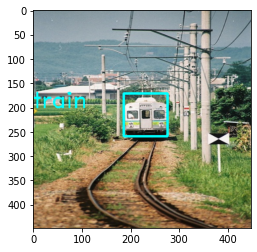

In [94]:
np_img = cv2.imread('./datalab-2021-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()

可以從此視覺化結果中看出，相比一開始只純粹用 yolo，可能會將 train 預測成 car 等，透過這些方法使得最後的預測效果還不錯

In [95]:
## 單獨 model 結果
import sys
sys.path.insert(0, './evaluate')
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction_resnet.txt', 'test_prediction_resnet.csv')

End Evalutation


## Ensemble

我們將不同的模型所預測出的 Bounding box 使用 Non-max suppression 進行挑選，並將挑選後的結果做為最終的預測結果。我們合併的模型如下：
1. Resnet 152
2. Xception

最終預測結果的 Public Score 為 0.42914、Private Score 為 ，相較以上單獨兩個模型出來的結果，表現是最好的

In [96]:
def swapBox(box):
    box[:,[0,1,2,3]] = box[:,[1,0,3,2]]
    return box

def execute_non_max(ori_box, ori_score, ori_class):
    # ori_class => number
    boxes = tf.Variable(ori_box, dtype=tf.float32)
    scores = tf.Variable(ori_score, dtype=tf.float32)
    
    selected_indices = tf.image.non_max_suppression(boxes, scores,
                                                    20, iou_threshold=IOU_THRES)
    
    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy().tolist()
    selected_class = [ori_class for _ in range(selected_boxes.shape[0])]
    
    return selected_boxes, selected_scores, selected_class

def cal_non_max(original_box, class_number, conf):
    original_box = swapBox(original_box)
    
    selected_boxes = np.array([[0., 0., 0., 0.]])
    selected_scores = []
    selected_class = []
    
    class_set = set(class_number)
    for i in class_set:
        curr_idx = [j for j in range(len(class_number)) if class_number[j] == i]
        curr_boxes = original_box[curr_idx,:]
        curr_scores = [conf[j] for j in curr_idx]
        
        curr_selected_boxes, curr_selected_scores, curr_selected_class = execute_non_max(curr_boxes, curr_scores, i)
        
        selected_boxes = np.concatenate((selected_boxes, curr_selected_boxes), axis=0)
        selected_scores.extend(curr_selected_scores)
        selected_class.extend(curr_selected_class)
    
    selected_boxes = swapBox(selected_boxes)
    selected_boxes = selected_boxes[1:, :]
    
    tmp_scores = np.array(selected_scores)
    order_list = tmp_scores.argsort().tolist()
    order_list = order_list[::-1]
    
    output_boxes = selected_boxes[order_list,:]
    output_scores = [selected_scores[j] for j in order_list]
    output_class = [selected_class[j] for j in order_list]
    
    return output_boxes.tolist(), output_scores, output_class

In [97]:
class ensemble_obj_detect(object):
    def __init__(self, file_list, path_to_file):
        self.path_to_file = path_to_file
        self.mapping_dict = {}

        self.image_order = []

        for f in file_list:
            tmp_dict, tmp_image_order = self.read_file(f)
            self.mapping_dict[f] = tmp_dict

            if len(self.image_order) == 0:
                self.image_order = tmp_image_order

    def read_file(self, file_name):
        output_dict = {}
        output_image_order = []

        with open(self.path_to_file + file_name) as f:
            for line in f:
                ss = line.strip().split()
                image_name = ss[0]
                line_data = ss[1:]

                output_dict[image_name] = []
                output_image_order.append(image_name)

                for i in range(len(line_data) // 6):
                    curr_data = [
                        float(j) for j in line_data[6 * i:6 * (i + 1)]
                    ]
                    output_dict[image_name].append(curr_data)

        return output_dict, output_image_order

    def ensemble(self, weights=None):
        self.reshape_dict = {}

        for file_name in self.mapping_dict.keys():
            tmp_dict = self.mapping_dict[file_name]

            for image_name in tmp_dict.keys():
                if image_name not in self.reshape_dict.keys():
                    self.reshape_dict[image_name] = tmp_dict[image_name].copy()
                else:
                    self.reshape_dict[image_name].extend(tmp_dict[image_name])

        self.perform_ensemble()
        self.clean()

    def perform_ensemble(self):
        self.ensemble_dict = {}

        for image_name in self.reshape_dict.keys():
            tmp_array = np.array(self.reshape_dict[image_name])
            boxes = tmp_array[:, :4]
            class_list = tmp_array[:, 4].tolist()
            scores_list = tmp_array[:, 5].tolist()

            x_same_bool = boxes[:, 0] == boxes[:, 2]
            boxes[x_same_bool, 2] += 0.5

            y_same_bool = boxes[:, 1] == boxes[:, 3]
            boxes[y_same_bool, 3] += 0.5

            output_box, output_score, output_class = cal_non_max(
                boxes, class_list, scores_list)

            np_box = np.array(output_box)

            np_score = np.array(output_score)
            np_score = np_score.reshape((np_box.shape[0], 1))

            np_class = np.array(output_class)
            np_class = np_class.reshape((np_box.shape[0], 1))

            output = np.concatenate((np_box, np_class, np_score), axis=1)

            # sort array from max to min
            output = output[output[:, 5].argsort()[::-1], :]
            output = self.remove_low_confidence(output)

            self.ensemble_dict[image_name] = output.tolist()

    def clean(self):
        for image_name in self.ensemble_dict.keys():
            if len(self.ensemble_dict[image_name]) > 1:
                new_list = []
                for box in self.ensemble_dict[image_name]:
                    if int(box[0]) != int(box[2]) and int(box[1]) != int(
                            box[3]):
                        new_list.append(box)

                if len(new_list) == 0:
                    new_list.append([0., 0., 0., 0., 0., 0.])

                self.ensemble_dict[image_name] = new_list

            assert len(self.ensemble_dict[image_name]) >= 1, "No box?"

    @staticmethod
    def remove_low_confidence(whole_array):
        if whole_array.shape[0] == 1:
            return whole_array

        high_conf = whole_array[:, 5] > PROB_THRES

        if np.sum(high_conf) == 0:
            # all low => return highest
            return whole_array[[0], :]
        else:
            return whole_array[high_conf, :]

    def write_ensemble(self, file_name):
        with open(file_name, "w") as f:
            for image_name in self.image_order:
                f.write(image_name)

                for to_write in self.ensemble_dict[image_name]:
                    f.write(" %d %d %d %d %d %.6f" %
                            (to_write[0], to_write[1], to_write[2],
                             to_write[3], to_write[4], to_write[5]))

                f.write("\n")

In [99]:
ensem = ensemble_obj_detect(file_list=["test_prediction_Resnet_paper_with_rg_30epoch.txt",
                                        "test_prediction_xception.txt"],
                             path_to_file="./")
ensem.ensemble()
ensem.write_ensemble("./ensemble.txt")

In [100]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./ensemble.txt', './ensemble.csv')

End Evalutation


# **Appendix (YOLO V2)**

在本次競賽中，我們另外也有嘗試使用YOLOv2，YOLOv2是建立在YOLOv1架構上做一些改進，根據許多論文也表示YOLOv2相較於YOLOv1能預測更準、更快且種類更多，以下為實作的程式碼:

In [36]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import os
import xml.etree.ElementTree as ET
import seaborn as sns
import numpy as np
import copy
import cv2 

2021-11-29 18:15:34.143772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 18:15:34.144215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 18:15:34.144540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 18:15:34.144916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 18:15:34.145290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

## **Hyperparameters**

在YOLOv2中，為了改善YOLOv1在精準定位物體上表現較差的缺點，他改為利用不同形狀的anchors box來計算與實際框的偏移量和confidence。

而另外還有個不同是，YOLOv2的輸入圖片size為416x416，這是因為經由圖片經由down sampling後，可以輸出13x13的feature map，搭配grid size，可以使每個grid中只有一個cell，因此對於偵測物體的邊界可以較為準確。

In [2]:
train_image_folder = "datalab-2021-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/"
train_annot_folder = "datalab-2021-cup2-object-detection/VOCdevkit_train/VOC2007/Annotations/"

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
BOX = int(len(ANCHORS)/2)
CLASS = len(LABELS)

LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

## **Data Preprocessing**

首先會進行資料前處理，這邊先讀檔存放在array方便使用

In [3]:
## parses the annotations from the XML files and stores it in an array
def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

由於每張圖片有不同大小，故在訓練之前會先resize，並找尋圖片中object邊界

In [4]:
## resized image and get all objects in the image
class ImageReader(object):
    def __init__(self,IMAGE_H,IMAGE_W, norm=None):
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm    = norm
        
    def encode_core(self,image, reorder_rgb=True):     
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
    
    def fit(self,train_instance):
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
                
        image_name = train_instance['filename']
        image = cv2.imread(image_name)
        h, w, c = image.shape
        if image is None: print('Cannot find ', image_name)
      
        image = self.encode_core(image, reorder_rgb=True)
            
        if "object" in train_instance.keys():
            
            all_objs = copy.deepcopy(train_instance['object'])     

            # fix object's position and size
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

In [ ]:
## normalize image
def normalize(image):
    return image / 255.

由於YOLOv2主要藉由anchorbox來預測，所以必須為每個object找尋最佳的anchorbox，而判斷最佳與否主要藉由IoU來作為標準

In [6]:
## finds the best anchor box
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS)//2))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union
    
    def find(self,center_w, center_h):
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
        shifted_box = BoundBox(0, 0,center_w, center_h)
        for i in range(len(self.anchors)):
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
        return(best_anchor,max_iou)    
    
    
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        self.confidence      = confidence
        self.set_class(classes)
        
    def set_class(self,classes):
        self.classes = classes
        self.label   = np.argmax(self.classes) 
        
    def get_label(self):  
        return(self.label)
    
    def get_score(self):
        return(self.classes[self.label])

取得邊框的4個偏移值center_x,center_y,center_w,center_h，可以利用這些值來計算實際邊框的中心位置和長寬

In [7]:
def rescale_centerxy(obj,config):
    center_x = .5*(obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = .5*(obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return(center_x,center_y)

def rescale_cebterwh(obj,config):   
    # unit: grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) 
    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) 
    return(center_w,center_h)

將data依據batchsize來將圖片和對應的object打包

In [8]:
class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm=None, shuffle=True):
        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))  

        for train_instance in self.images[l_bound:r_bound]:
            img, all_objs = self.imageReader.fit(train_instance)
            
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_cebterwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box 
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. 
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 
                        
                        
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

In [9]:
train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))
print("Number of train_annotation = {}".format(len(seen_train_labels)))

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

N train = 5011
Number of train_annotation = 20


In [10]:
[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


## **Yolo_v2 model**

除了上述提到的anchor box，YOLOv2和YOLO還有一個明顯的差別，就是在每層卷積層的後面都會加入batch normalization層，這是為了可以提升 model收斂速度並且降低overfitting的狀況，下方為YOLOv2 model:

In [11]:
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

yolov2 = Model([input_image, true_boxes], output)

2021-11-29 16:16:55.722371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 16:16:55.722986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 16:16:55.723503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 16:16:55.724204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 16:16:55.724747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [12]:
yolov2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 416, 416, 32  128         ['conv_1[0][0]']                 
                                )                                                             

## **Loss function**

調整output的輸出

In [13]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX): 
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    cell_y = tf.transpose(cell_x, (0,2,1,3,4)) 
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return(cell_grid) 

In [14]:
def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):    
    BOX = int(len(ANCHORS)/2)
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid 
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) 
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    pred_box_class = y_pred[..., 5:] 
    
    return(pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class)

取得ground_truth對應的輸出

In [16]:
def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] 
    true_box_wh    = y_true[..., 2:4] 
    true_box_conf  = y_true[...,4]   
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)

計算bounding box的loss

In [17]:
def calc_loss_xywh(true_box_conf, COORD_SCALE, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh): 
    coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * LAMBDA_COORD 
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.

    return (loss_xy + loss_wh, coord_mask)

計算object種類的loss值

In [18]:
def calc_loss_class(true_box_conf,CLASS_SCALE, true_box_class,pred_box_class):
    class_mask   = true_box_conf  * CLASS_SCALE 
    
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, 
                                                                  logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)   
    return(loss_class)

計算confidence的loss

In [19]:
def get_intersect_area(true_xy,true_wh,
                       pred_xy,pred_wh):
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)    
    return(iou_scores)

def calc_IOU_pred_true_assigned(true_box_conf,
                                true_box_xy, true_box_wh,
                                pred_box_xy,  pred_box_wh):
    iou_scores        =  get_intersect_area(true_box_xy,true_box_wh,
                                            pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return(true_box_conf_IOU)

In [20]:
def calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):   
    true_xy = true_boxes[..., 0:2]          
    true_wh = true_boxes[..., 2:4]           
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) 
    pred_wh = tf.expand_dims(pred_box_wh, 4) 
    
    iou_scores  =  get_intersect_area(true_xy,
                                      true_wh,
                                      pred_xy,
                                      pred_wh)

    best_ious = tf.reduce_max(iou_scores, axis=4) 
    return(best_ious)

In [21]:
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT):    
    conf_mask = tf.cast(best_ious < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return(conf_mask)

In [22]:
def calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf):  
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    return(loss_conf)

將上述的三種loss值算出加總，即可得到Total loss

In [23]:
def custom_loss(y_true, y_pred):
    total_recall = tf.Variable(0.)
    
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)

    
    loss = loss_xywh + loss_conf + loss_class
    

    
    return loss

## **Train**

In [24]:
dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass

true_boxes = tf.constant(b_batch,dtype="float32")
early_stop = EarlyStopping(monitor='loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

In [25]:
optimizer = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
yolov2.compile(loss=custom_loss ,optimizer=optimizer)

tf.config.experimental_run_functions_eagerly(True)

yolov2.fit_generator(generator        = train_batch_generator, 
                    steps_per_epoch  = len(train_batch_generator), 
                    epochs           = 150, 
                    verbose          = 1,
                    callbacks        = [early_stop], 
                    max_queue_size   = 3)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


/home/joshmann/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_2401632/1908621951.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  yolov2.fit_generator(generator        = train_batch_generator,
/home/joshmann/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/150


2021-11-29 16:16:57.976724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


314/314 [==============================] - 152s 473ms/step - loss: 115.0344
Epoch 2/150
314/314 [==============================] - 149s 473ms/step - loss: 27.6753
Epoch 3/150
314/314 [==============================] - 149s 474ms/step - loss: 25.0984
Epoch 4/150
314/314 [==============================] - 149s 475ms/step - loss: 23.4901
Epoch 5/150
314/314 [==============================] - 150s 477ms/step - loss: 22.4211
Epoch 6/150
314/314 [==============================] - 150s 476ms/step - loss: 20.8686
Epoch 7/150
314/314 [==============================] - 150s 476ms/step - loss: 20.6254
Epoch 8/150
314/314 [==============================] - 149s 474ms/step - loss: 21.8745
Epoch 9/150
314/314 [==============================] - 149s 475ms/step - loss: 19.9302
Epoch 10/150
314/314 [==============================] - 149s 475ms/step - loss: 19.2804
Epoch 11/150
314/314 [==============================] - 149s 474ms/step - loss: 19.4908
Epoch 12/150
314/314 [==============================

## **Predict and Save**

In [26]:
class OutputRescaler(object):
    def __init__(self,ANCHORS):
        self.ANCHORS = ANCHORS

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    def _softmax(self, x, axis=-1, t=-100.):
        x = x - np.max(x)

        if np.min(x) < t:
            x = x/np.min(x)*t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)
    def get_shifting_matrix(self,netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[...,0]
        
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
       
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:,igrid_w,:] = igrid_w

        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]
        return(mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H)

    def fit(self, netout):    
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        '''
        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        (mat_GRID_W,
         mat_GRID_H,
         mat_ANCHOR_W,
         mat_ANCHOR_H) = self.get_shifting_matrix(netout)


        # bounding box parameters
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np.exp(netout[..., 2]) * mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np.exp(netout[..., 3]) * mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self._sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return(netout)

In [27]:
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score() > obj_threshold:
                        boxes.append(box)
    return(boxes)

In [28]:
def nonmax_suppression(boxes,iou_threshold,obj_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = BestAnchorBoxFinder([])
    
    CLASS    = len(boxes[0].classes)
    index_boxes = []   
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c] for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                index_boxes.append(index_i)
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    bbox_iou = bestAnchorBoxFinder.bbox_iou(boxes[index_i], boxes[index_j])
                    if bbox_iou >= iou_threshold:
                        classes = boxes[index_j].classes
                        classes[c] = 0
                        boxes[index_j].set_class(classes)
                        
    newboxes = [ boxes[i] for i in index_boxes if boxes[i].get_score() > obj_threshold ]                
    
    return newboxes

In [29]:
def get_boxinfo(image, boxes, labels, obj_baseline=0.05):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", 8)
    boxinfo = []
    
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
 
        score = box.get_score()
        class_num = box.label
#         text = "{:10} {:4.3f}".format(labels[box.label], box.get_score())
        
#         print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        box_data = [xmin, ymin, xmax, ymax, class_num, score]
        save_box = True
        for i in range(len(boxinfo)):
            if box_data==boxinfo[i]:
                save_box = False
        if save_box:
            boxinfo.append(box_data)
#     print(boxinfo)
    return boxinfo  

In [37]:
test_img_dir = './datalab-2021-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/'
allFileList = os.listdir(test_img_dir)
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
obj_threshold = 0.015

output_file = open('./test_prediction.txt', 'w')
imageReader = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
for file in allFileList:
    out = imageReader.fit(test_img_dir + file)
    X_test = np.expand_dims(out,0)
    y_pred = yolov2.predict([X_test,dummy_array])
    for iframe in range(len(y_pred)):
        netout         = y_pred[iframe] 
        netout_scale   = outputRescaler.fit(netout)
        boxes          = find_high_class_probability_bbox(netout_scale,obj_threshold)
        if len(boxes) > 0:
            final_boxes    = nonmax_suppression(boxes,iou_threshold=0.02,obj_threshold=obj_threshold)
#         get_boxinfo(X_test[0],final_boxes,LABELS)
        boxinfo = get_boxinfo(X_test[0],final_boxes,LABELS)[0]
    output_file.write(file+" %d %d %d %d %d %f\n" %(boxinfo[0], boxinfo[1], boxinfo[2], boxinfo[3], boxinfo[4], boxinfo[5]))
#     print(file)
#     print(boxinfo)

output_file.close()

/home/joshmann/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/tmp/ipykernel_2401632/1022265868.py:6: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


***

# **Conclusion**

- **<font size="4">資料前處理（Data Preprocessing）</font>**
    - <font size="3"> 原本資料存在 imbalanced 的問題，這是很常出現的問題，故前面有對 labe 較少的樣本作增加，讓資料更為 balanced，最後在預測的成效上有較原始資料訓練來得佳，故符合我們猜測，資料不平衡會對模型造成混淆</font>
    - <font size="3"> 助教有提醒說資料只能使用此次提供的來進行訓練，故對資料進行 Augmentation，如翻轉、縮放和圖片飽和度調整等，讓模型的預測能力提高，這方法是我們認為讓分數提高的要點之一</font>
<br /><br />
- **<font size="4">模型建立與訓練（Model building and training）</font>**
    - <font size="3">這次模型的訓練時間較長，因此對於模型選擇或是其他步驟程式碼要更為小心熟練，有在訓練過程結束後才發現計算出來的值有問題或是 NA 值，這都是需要去避免的</font>
    - <font size="3">在最後的預測中，我們也可以發現到進行水平翻轉預測和預測結果 bounding box 的 ensemble 是可以讓整個分數提升的方法</font>
    - <font size="3">最後結果，我們的 Public Score 為 0.4291，而在 Private Score 為 0.4744，可見其成果有稍微退步</font>
    - <font size="3">在訓練 YOLO V2 過後，最終 loss 大約落在 4 就不會往下減少了，而我們有試著將結果輸出，但發現整體效果並不理想，不僅會框到意義不明的地方還會判斷成錯誤種類，這裡有歸納幾個可能原因:</font>
        - <font size="3">Hyperparameters 參數:在一個訓練 model 的過程中，參數調整對於整體的表現影響非常大，而 YOLOv2 還有一些特殊的參數，如: ANCHORS、BOX，這些都會影響 model 的預測結果，在查詢資料的過程我們有發現每個實作都會依照各自資料有不同的參數，但由於時間因素，此次並無法成功調整到一組好的參數</font>
        - <font size="3">資料前處理: 如前面的實作過程，資料前處理對於最終結果好壞也扮演了很重要的角色，也許未來可以再藉由資料前處理來平衡資料，來提升 model 預測結果</font>
<br /><br />
***

In [1]:
!jupyter nbconvert — to script DL_COMP2_{讓我活下來}_REPORT.ipynb

[NbConvertApp] WARNING | pattern '—' matched no files
[NbConvertApp] WARNING | pattern 'to' matched no files
[NbConvertApp] WARNING | pattern 'script' matched no files
[NbConvertApp] Converting notebook DL_COMP2_{讓我活下來}_REPORT.ipynb to html
[NbConvertApp] Writing 946195 bytes to DL_COMP2_{讓我活下來}_REPORT.html
